In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
# Suppress LightGBM specific warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm.basic')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm.engine')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm.callback')

# Pima Indians - Diabetes Dataset
https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data

**Mitko Stoychev**
11/05/2024

## 1. Introduction

**Context about this notebook**
This is one of my first data science projects. I will try to make an exhaustive EDA and then apply different machine learning models. I am open to any criticism and suggestions. I am just starting on this data journey, so I assume that this analysis could have some errors or many possible improvements.

**Context about the dataset**
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**What is Diabetes ?**
According to FDA, Diabetes is a chronic (long-lasting) health condition that happens when the level of glucose in blood (blood sugar) is too high. Insulin is a hormone made by the pancreas that helps move sugar out of blood and into cells for energy. An estimated 30 million people in the United States are living with diabetes. About 1 in 4 people living with diabetes don’t know they have it. Diabetes disproportionately affects racial and ethnic minorities and other diverse groups.

In the article "Diabetes: Living with a Chronic Disease" we can quote the following:

- "The year 2021 marked the 100th anniversary of the discovery of insulin. Before insulin was discovered, people with diabetes didn’t live long lives. Since then, we’ve come a long way in reducing the toll diabetes takes on people’s daily lives. But the fight isn’t over.

- Today, the number of people with diabetes is higher than it has ever been. And it’s not just your grandparents you have to worry about. People are developing diabetes at younger ages and at higher rates. But the more you know about diabetes, the more you can do about preventing it, delaying it, or lessening its harmful effects."

![Texto alternativo](https://cdn1.byjus.com/wp-content/uploads/2018/11/biology/2017/08/27111256/0diabeties001.jpg)


In the following notebook, I will try to analize which factors have more importance to diabetes disease. 

In the dataset, we can find the next features:
* 1. Pregnancies: number of times pregnant
* 2. Glucose: express the Glucose level in blood, Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* 3. BloodPressure: Diastolic blood pressure (mm Hg)
* 4. SkinThickness: Triceps skin fold thickness (mm)
* 5. Insulin: express the Insulin level in blood, 2-Hour serum insulin (mu U/ml)
* 6. BMI: Body Mass Index, (weight in kg/(height in m)^2)
* 7. DiabetesPedigreeFunction: Diabetes pedigree function to express the Diabetes percentage, 
* 8. Age: age (years)
* 9. Outcome: express the final result 1 is YES o is NO

## 2. Load the dataset

In [ ]:
data_original = pd.read_csv("data/diabetes.csv")
data_original

In [ ]:
# Good Practice → change column names to snakecase and lowercase
data_original.rename(columns={
    'Pregnancies': 'pregnancies',
    'Glucose': 'glucose',
    'BloodPressure': 'blood_pressure',
    'SkinThickness': 'skin_thickness',
    'Insulin': 'insulin',
    'BMI': 'bmi',
    'DiabetesPedigreeFunction': 'diabetes_pedigree_function',
    'Age': 'age',
    'Outcome': 'outcome'
}, inplace=True)

## 3. First look at the data

In [ ]:
data_original.info()

In [ ]:
data_original.describe()

At first glance I can see that the dataset is very small (768 entries) and there are **not** any **null values** in the dataset. That´s good because I don´t have to clean them.

However, we can see that there are **min values** equal to **zero**. This means that they are non-null, but empty data. This could confuse the model. I would have to deal with it later. 

Another point that catches my attention is the Insulin. The mean is 78.7 and the standard deviation is 115.2. This is very strange at first glance. It may be my ignorance on the subject. I would have to do more research on the behavior of insulin in the human body.

Another point to note is that some medical values have a minimum value equal to zero. It is totally impossible with the life of the human being. I will have to deal with it later.

Anyway let us explore the "outcome" column too take a first look for the diabetic distribution of the dataset.

In [ ]:
# OUTCOME COLUMN  → Check diabetes distribution among the patients 
data = data_original.copy()

data["outcome_cat"] = data["outcome"].map({0: "non-diabetic", 1: "diabetic"})
outcome_counts = data["outcome_cat"].value_counts()
labels = outcome_counts.index
counts = outcome_counts.values

data.drop(["outcome_cat"], axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(6,3))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Diabetes Distribution')
plt.axis('equal')
plt.legend()
plt.show()

This dataset has approx. 35% of the population with a diabetic disease.

This is striking to me because the proportion of diabetes in the world is of 10.5% of the adult population (20-79 years) according to the IDF Diabetes Atlas (2021) reports. In any case, I will keep it in mind this initial exploration highlights a potential class imbalance within the data.

Before proceeding to the exploration of the data, I am concerned about data equal to zero. It is logical that these rows are not real medical values, but they are empty and may confuse my analysis. I will try to manage them in such a way that they do not hinder my exploration.

## 4. Outlier detection.

At first, I will use Tukey’s method, which is widely used for exploratory data analysis and has become a standard approach for identifying outliers in statistical and data analysis practices. John Tukey looks at the data’s spread using the Interquartile Range (IQR).

After that I will take a look at the features: "glucose", "blood_pressure", "skin_thickness", "insulin" and "bmi" equal to zero. It´s impossible value with the existence of human beings. How many records do we have with this condition?

Since the dataset has clear errors when recording the data, first I thought of checking if we have duplicate lines.

In [ ]:
# Check for duplicates
data[data.duplicated()]

We can see that we have no duplicate rows.

So let´s use the IQR to drop the outliers.

In [ ]:
def outlier_detection(data, features):
    """
    Takes a dataframe and a list of the columns to apply Tukey's method for detecting outliers.
    Returns a dictionary where keys are column names and values are lists of indices considered outliers.
    """
    outliers = {}
    for feature in features:
        q1 = data[feature].quantile(0.25)
        q3 = data[feature].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        feature_outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].index.tolist()
        outliers[feature] = feature_outliers
    return outliers

In [ ]:
outliers_to_drop = outlier_detection(data, ["glucose", "blood_pressure", "skin_thickness", "insulin", "bmi"])

In [ ]:
unique_indices = set()
total_outliers = 0

# Collecting unique indices and counting outliers
for indices in outliers_to_drop.values():
    unique_indices.update(indices)
    total_outliers += len(indices)

unique_indices_list = list(unique_indices)
unique_count = len(unique_indices_list)
print(unique_count)

Having 93 outliers out of a dataset with 768 instances is indeed a substantial number, constituting around 12% of the data.
For obvious reasons I cannot delete all the rows.

Given these considerations, it's advisable to analyze each feature individually and decide on the appropriate action for handling outliers. I will document decision-making process to justify any data transformations in my analysis.

So, let's see how we manage this problem. Let´s see if correlations give us an idea about the importance of the features.

In [ ]:
# Heatmap to check any correlations
plt.figure(figsize=(8,4))
sns.heatmap(data.corr(), annot=True, linewidth=1, cmap="Reds")
plt.show()

With the **Pearon Correlation method** is seems that only "glucose", "bmi", "age" and maybe "pregnancies" feature seem to have some low correlation with the survival probability.

It **doesn't mean that the other features are not usefull**. In one hand, it is well known to all that insulin treatment is prescribed in diabetics. In the other hand, subpopulations in these features can be correlated with diabetic disease. To determine this, we need to explore in detail these features by grouping. But first let´s mange the zero values.

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(data.corr()["outcome"].sort_values(ascending=False)[1:],label="Correlation for Outcome",color="blue")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.grid(True)
plt.legend()
plt.show()

We can see that "glucose" and "bmi" are the most correlated with the diabetes desease. So let´s explore them first.

In [ ]:
# Check for impossible glucose zero values 
impossible_zeros_glucose = data[data['glucose'] == 0]
impossible_zeros_glucose

The impossible glucose values are row 75, 182, 242, 349 and 502. 

I can note insuline value is missing too. Considering that both values have impact in the diabetes prevalence and that this small dataset with 768 rows, deleting these rows might not significantly affect the analysis. 

For me fill these values with an invented value (arithmetic mean, for example) is worse decision. I am working with a medical dataset, so making up medical test results does not seem to be the best idea.

In [ ]:
# Replace impossible zero values with NaN
data['glucose'] = data['glucose'].replace(0, float('nan'))

# Drop rows with empty 'Glucose' and 'Insulin' values
data.dropna(subset=['glucose'], inplace=True)

print(f"I have already deleted {len(impossible_zeros_glucose['glucose'])} rows with glucose=0 value and the current shape is of the data is: {data.shape}")

In [ ]:
# Check for impossible bmi zero values 
impossible_zeros_bmi = data[data['bmi'] == 0]
impossible_zeros_bmi

Due to the importance of the correlation of the bmi and the outcome and the small number of these 11 records, I decide to eliminate them.

In [ ]:
# Replace impossible zero values with NaN
data['bmi'] = data['bmi'].replace(0, float('nan'))

# Drop rows with empty 'Glucose' and 'Insulin' values
data.dropna(subset=['bmi'], inplace=True)

print(f"I have already deleted {len(impossible_zeros_bmi['glucose'])} rows with bmi=0 value and the current shape is of the data is: {data.shape}")

Let´s see how much "impossible zero values" is left and how we can manage it. But before I will replace them with a np.nan value just to manage them more easily.

In [ ]:
# replace "impossible zero" value with "np.nan" value
data[['insulin','blood_pressure','skin_thickness']] = data[['insulin','blood_pressure','skin_thickness']].replace(0, np.NaN)

In [ ]:
data.isnull().sum()

I am very **concerned about the "insulin" column**. The **missing values** reprensent almost **48% of the data** and we must not forget the importance of that hormone. It is well known about as a universal way to control diabetes with its measurements at the blood level. I am very concerned about filling this value with an "invented value" (mean, median or mode). I find it very worrying and it can lead to errors in the analysis.

To fill these Nan values the data distribution needs to be understood.

In [ ]:
skewness_results = data[["insulin", "skin_thickness", "blood_pressure"]].apply(lambda x: x.skew())
print(skewness_results)

data.hist(["insulin", "skin_thickness", "blood_pressure"], figsize=(6,3), layout=(1, 3))
plt.show()

Based on my analysis of the data and considering the characteristics of each feature, my considerations about handling missing values are the next:

**1. Insulin**

Since insulin levels are crucial for managing diabetes, it's **risky to fill missing values with invented values**. Given the significant number of missing values (almost 48%), deleting the column might be a viable option, especially if there are other features that can adequately capture the information insulin would provide. Alternatively, I could consult with a domain expert for guidance, but since I do not have access to this option, I choose to eliminate the "insulin" column.  ***→ drop insulin column***


**2. Blood Pressure**

With only 28 missing values and a low skewness, filling them with the arithmetic mean seems reasonable. I could also consider using more sophisticated imputation methods, such as K-nearest neighbors (KNN) imputation, which takes into account the relationships between features. But in this particular case it seems that it is not worth it and does not give more value to the data. ***→ fill with the arithmetic mean***


**3. Skin Thickness**

Filling missing values with the median might be a reasonable approach, given the relatively high skewness, as the median is less affected by extreme values. Considering the potential correlation  of the triceps skin fold thickness (mm) with the body mass index, I could explore filling missing values based on the relationship between "skin_thickness" and "bmi".  ***→ fill with the arithmetic mean***

In [ ]:
# 1. Insulin
data.drop(["insulin"], axis=1, inplace=True)

In [ ]:
# 2. Blood Pressure
data["blood_pressure"].fillna(data["blood_pressure"].mean(), inplace=True)

In [ ]:
# 3. Skin thickness
# Impute missing values for skin thickness using K-nearest neighbors (KNN) imputation
def impute_skin_thickness(data):
    impute_data = data[["skin_thickness", "bmi"]]

    # Initialize KNN imputer
    imputer = KNNImputer(n_neighbors=5) 

    # Perform imputation
    imputed_values = imputer.fit_transform(impute_data)

    # Replace original skin_thickness values with imputed values
    data["skin_thickness"] = imputed_values[:, 0]

    return data

In [ ]:
# call the method and impute missing values for skin thickness
data = impute_skin_thickness(data)

In [ ]:
data.isna().sum()

## 5. Explore the data

In [ ]:
# Heatmap to check any correlations
plt.figure(figsize=(8,4))
sns.heatmap(data.corr(), annot=True, linewidth=1, cmap="Reds")
plt.show()

In [ ]:
# GROUPING BY "pregnancies"
data.groupby(["pregnancies"])["outcome"].agg(['mean', 'count'])

Women with higher numbers of pregnancies, particularly 7 or more, tend to have a higher mean outcome of diabetes. This indicates that having a higher number of pregnancies might be associated with an increased risk of diabetes.

In [ ]:
# GROUPING BY "glucose"

# Define bins for glucose levels
bins = [0, 100, 125, 150, 200, float('inf')]
labels = ['<100', '100-125', '125-150', '150-200', '>=200']

# Group by glucose bins and calculate mean outcome
grouped_data = data.groupby(pd.cut(data['glucose'], bins=bins, labels=labels, right=False), observed=True)['outcome'].mean().reset_index()

# Plotting
plt.figure(figsize=(6, 3))
sns.barplot(x='glucose', y='outcome', data=grouped_data)
plt.title('Probability of having a positive outcome given a specific range of glucose levels')
plt.xlabel('Glucose Level')
plt.ylabel('Mean Outcome')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Exploring Glucose Distribution
sns.histplot(data["glucose"], color="m", kde=True)
plt.title("Glucose Distribution")
plt.xlabel("Glucose")
plt.ylabel("Frequency")
plt.text(150, 75, "Skewness: %.2f" % data["glucose"].skew(), fontsize=12)
plt.show()

Despite being slightly right-skewed, the distribution appears relatively symmetrical overall, with a single peak and a gradual decrease in frequency as glucose levels increase.

In [ ]:
# Exploring Blood Pressure Distribution
sns.histplot(data["blood_pressure"], color="r", kde=True)
plt.title("Blood Pressure")
plt.xlabel("Blood Pressure [mm Hg]")
plt.ylabel("Frequency")
plt.text(95, 60, "Skewness: %.2f" % data["blood_pressure"].skew(), fontsize=12)
plt.show()

The distribution of blood pressure values appears to be relatively symmetric or slightly right-skewed, as indicated by the skewness value of 0.14. This suggests that there is a roughly equal spread of blood pressure values on both sides of the mean.

Note that I have filled 28 missing values with the mean and this has influenced the distribution by shifting it slightly towards the mean value. This is reflected in the skewness value, which is close to zero, indicating a more symmetric distribution compared to the original dataset.

In [ ]:
# Exploring Body Mass Index Distribution
sns.histplot(data["bmi"], color="b", kde=True)
plt.title("Body Mass Index (BMI)")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.text(50, 50, "Skewness: %.2f" % data["bmi"].skew(), fontsize=12)
plt.show()

The positive skewness value 0.60 indicates that the distribution of BMI values is moderately right-skewed. This means that the tail of the distribution extends more towards higher BMI values, and there are relatively fewer instances of very low BMI values compared to very high ones.

*Note:* **The normal BMI according to World Health Organization is 18.5-24.9.**




The right-skewed distribution of BMI values suggests that there may be a larger proportion of individuals with higher BMI values in the dataset. This information is valuable for understanding the distribution and characteristics of BMI values, which are important indicators of overall health and risk factors for various health conditions.

In [ ]:
# Exploring skin_thickness Distribution → ORIGINAL DATA
sns.histplot(data_original["skin_thickness"], color="black", kde=True)
plt.title("ORIGINAL DATA → Skin Thickness")
plt.xlabel("Skin Thickness")
plt.ylabel("Frequency")
plt.text(70, 50, "Skewness: %.2f" % data_original["skin_thickness"].skew(), fontsize=12)
plt.show()

In [ ]:
# Exploring skin_thickness Distribution
sns.histplot(data["skin_thickness"], color="g", kde=True)
plt.title("CLEAN DATA → Skin Thickness")
plt.xlabel("Skin Thickness")
plt.ylabel("Frequency")
plt.text(70, 80, "Skewness: %.2f" % data["skin_thickness"].skew(), fontsize=12)
plt.show()

In the **original data histogram**, the distribution of skin thickness in the original data (before cleaning) appears to be approximately symmetric or slightly right-skewed, likely **due to the presence of zero values** representing missing or invalid measurements. This is totally wrong.

The **cleaned data histogram**, the distribution of skin thickness in the cleaned data shows a **noticeable right skew**, indicating that the removal or adjustment of false zero values led to a change in the shape of the distribution. The skewness value of 0.71 for the cleaned data confirms a right skew in the distribution of skin thickness after addressing the false zero values, reflecting a more accurate representation of the data. 

This result gives me a lot of confidence, because BMI is highly correlated with body composition and is clearly related to "skin_thickness" or Triceps skin fold thickness (mm). These two medical estimates are used as a tool to measure body fat and therefore the state of health of humans.

In [ ]:
# Exploring Diabetes Pedigree function
sns.histplot(data["diabetes_pedigree_function"], color="y", kde=True)
plt.title("Diabetes Pedigree Function")
plt.xlabel("Diabetes pedigree function")
plt.ylabel("Frequency")
print(data["diabetes_pedigree_function"].skew())
plt.show()

The Diabetes Pedigree Function (DPF) is a numerical score that quantifies the diabetes mellitus history in relatives of individuals who are part of the Pima Indian population. It provides a measure of the likelihood of diabetes based on family history. This function is used as a predictor or feature in diabetes prediction models.

The right-skewed distribution of Diabetes Pedigree Function scores suggests that there may be a larger proportion of individuals with lower scores (indicating a lower likelihood of diabetes based on family history) in the dataset. However, the presence of outliers in the right tail of the distribution indicates that there are also individuals with higher scores, suggesting a higher likelihood of diabetes based on family history. 

In [ ]:
# Grouping by Age 
sns.displot(data, x="age", col="outcome", bins=8)
plt.show()

The proportion of diabetes outcomes being only 35% indicates that diabetes is not highly prevalent in the dataset, but it still a really big prevalence for an desease.

Both histograms show a decreasing trend in prevalence as age increases. But this **is NOT suggesting that older individuals are less likely to have diabetes compared to younger individuals**. The reality is that we have more young age participants in the dataset than older ones.


In [ ]:
data.isna().sum()

## 6. Scaling the data

Scaling data is a crucial step in many machine learning algorithms because it ensures that features contribute equally to the model's performance. This process adjusts the range of feature values so that no single feature dominates the others due to its scale.

**1. Equal Contribution of Features and Distance-Based Algorithms**:
   
Different features in your dataset may have different units or scales. For instance, in a dataset with features such as "age" (0-100 years) and "income" (0-100,000 dollars), the range of values varies significantly. Without scaling, features with larger ranges can dominate the distance calculations and model training. Algorithms that rely on distance metrics (e.g., k-nearest neighbors (KNN)) are particularly sensitive to the scale of data. If one feature has a larger scale, it can disproportionately influence the calculation of distances, leading to biased results.

**2. Improving Convergence of Gradient Descent**:

Algorithms like gradient descent converge faster with scaled data. When features are on similar scales, the optimization process can progress more smoothly and reach the minimum more efficiently.

In [ ]:
data_copy = data.copy(deep=True)

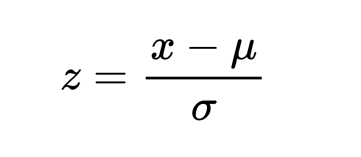

In [ ]:
# Define columns to scale (excluding "outcome")
columns_to_scale = ["pregnancies", "glucose", "blood_pressure", "skin_thickness", "bmi", "diabetes_pedigree_function", "age"]

# Compute mean and standard deviation for each column
mean_values = data[columns_to_scale].mean()
std_values = data[columns_to_scale].std()

# Scale the data using z-scores
data_scaled = (data[columns_to_scale] - mean_values) / std_values

# Concatenate the scaled DataFrame with the original DataFrame (excluding "outcome")
data = pd.concat([data.drop(columns=columns_to_scale), data_scaled], axis=1)
data

## 7. Train Test Split

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a **test set**:  *X_test, y_test*.

**Train Test Split**: Split the data into a training and test sets. We hide the test set from the algorith to have unknown datapoints to test the data rather than testing with the same points with which the model was trained. This helps capture the model performance much better.

![Train Test Split](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/1_train-test-split_0.jpg)

I assume that distribution of the target variable in the original dataset is representative of the real-world distribution for Pyma Indians, and I want to ensure that the train and test sets have a similar distribution, then using stratified sampling would be appropriate.

In [ ]:
X = data.drop(columns=['outcome'])  # Features
y = data['outcome']  # Target variable

# Split the data into train and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 8. Modelling

In this notebook I am going to use **10 of the most popular classifiers**:
- Logistic Regression (LR)
- K-Neighbors Classifier (KNN) 
- Support Vector Classifier (SVC)
- Decision Tree Classifier (DTC)
- Random Forest Classifier (RFC)
- Ada Boost Classifier (Adaboost)
- Gradient Boosting Classifier (‎GBM)
- XGB Classifier (XGBoost)
- LightGBM Classifier (LightGBM)
- Cat Boost Classifier (CatBoost)

### 8.1. Base Model Classifiers

**Cross Validation** is a widely used technique for evaluating model performance and subsequent trend checking in machine learning. It consists of partitioning the data into subsets (parts), where one subset is used for training and another subset is used to test and evaluate model performance.
- The partitioned data is the training data (80% of the original data)
- K-fold: the training set is randomly divided into K subsets of approximately the same size, then K iterations are performed, where K-1 subsets are for training and 1 for validation.
- The performance computed by k-fold cross-validation is the average of all the values computed in each iteration.


**Grid Search Cross Validation**

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Grid Search Cross Validation" width="500">

**scoring="roc_auc"** → (**Receiver Operating Characteristic** - Area Under Curve):
1. Definition: The ROC AUC score is a measure of a classifier’s ability to distinguish between classes. It is the area under the ROC curve, which plots the true positive rate (recall) against the false positive rate (1-specificity) at various threshold settings.
2. Interpretation: The ROC AUC score ranges from 0 to 1. A score of 0.5 suggests no discriminative power (equivalent to random guessing), while a score of 1 indicates perfect discrimination.
3. Usage: The ROC AUC score is particularly useful for binary classification problems and **is less sensitive to class imbalance than accuracy**. 

**The confusion matrix**

The confusion matrix is a technique used for summarizing the performance of a classification algorithm (binary outputs).

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*9r99oJ2PTRi4gYF_.jpg" alt="The confusion Matrix" width="500">


**Note**: This is medical datasets, the **worst case scenario is Type II error**, for obvious reasons. Minimizing Type II errors (false negatives) is crucial. A Type II error in this context means failing to identify a patient who has diabetes, which could result in the patient not receiving necessary treatment.

In [ ]:
random_state = 23

In [ ]:
classifiers = [('LR', LogisticRegression(random_state=random_state)),
                ('KNN', KNeighborsClassifier()),
                ("SVC", SVC(random_state=random_state)),
                ("DTC", DecisionTreeClassifier(random_state=random_state)),
                ("RFC", RandomForestClassifier(random_state=random_state)),
                ('Adaboost', AdaBoostClassifier(random_state=random_state)),
                ('GBM', GradientBoostingClassifier(random_state=random_state)),
                ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)),
                ('LightGBM', LGBMClassifier(objective='binary', verbose=-1, random_state=random_state)),
                ('CatBoost', CatBoostClassifier(verbose=False, random_state=random_state))]

In [ ]:
def base_models(X_train, y_train, X_test, y_test, classifiers, scoring="roc_auc"):
    """
    Evaluates a set of classification models using cross-validation and plots confusion matrices.

    Parameters:
    X_train : sparse matrix, shape (n_samples, n_features)
        The training features.
    X_test : sparse matrix, shape (n_samples, n_features)
        The testing features.
    y_train : array-like, shape (n_samples,)
        The training target values.
    y_test : array-like, shape (n_samples,)
        The testing target values.
    classifiers: list of tuples
        List of (name, model) tuples of the classifiers to evaluate.
    scoring : string, default: "roc_auc"
        Scoring metric to evaluate the models.

    Returns:
    None

    This function prints the mean cross-validation score for each classifier and plots the confusion matrix.
    """
    for name, classifier in classifiers:
        # Cross-validate the model
        cv_results = cross_validate(classifier, X_train, y_train, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

        # Train the model on the entire training set
        classifier.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = classifier.predict(X_test)
        
        # Compute the confusion matrix
        cnf_matrix = confusion_matrix(y_test, y_pred)

        # Print confusion matrix results
        tn, fp, fn, tp = cnf_matrix.ravel()
        print(f"True positives: {tp}, False positives: {fp}, False negatives: {fn}, True negatives: {tn}")
        
        # Plot the confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        plt.title(f'Confusion matrix for {name}', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()

In [ ]:
base_models(X_train, y_train, X_test, y_test, classifiers, scoring="roc_auc")

At first sight it seems that the best model is the Linear Regression roc_auc: 0.8305 (LR). However, we can see that it is the one with the most Type II errors.

Therefore, taking into account the confusion matrix, I will optimize 3 models with the less number of Type II errors which are as follows:
1. GBM → roc_auc: 0.803 (GBM) → 23 Type II errors and 11 Type I errors → *34 total errors*
2. LightGBM → roc_auc: 0.7946 (LightGBM) → 24 Type II errors and 11 Type I errors → *35 total errors*
3. Adaboost → roc_auc: 0.7888 (Adaboost)  → 25 Type II errors and 12 Type I errors → *37 total errors*

In [ ]:
# save these results in a variable
base_model_errors = {"GBM": {"Type II(fn)": 23, "Type I(fp)": 11, "total": 34},
                    "LightGBM": {"Type II(fn)": 24, "Type I(fp)": 11, "total": 35},
                    "Adaboost": {"Type II(fn)": 25, "Type I(fp)": 12,"total": 37}}

### 8.2. Hyperparameter Optimization

In [ ]:
# DEFINE HYPERPARAMETERS FOR OPTIMIZATION
gbm_params = {
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

lgbm_params = {
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 3, 5],
    'num_leaves': [31, 40, 50],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
    
adaboost_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.05]
}

In [ ]:
classifiers_tunned= [('GMB', GradientBoostingClassifier(random_state=random_state), gbm_params),
                     ("LightGBM", LGBMClassifier(objective='binary', verbose=-1, random_state=random_state), lgbm_params),
                     ('Adaboost', AdaBoostClassifier(random_state=random_state), adaboost_params)]

In [ ]:
def evaluate_and_optimize_models(X_train, y_train, X_test, y_test, classifiers_tunned, scoring="roc_auc"):
    """
    Evaluates and optimizes a set of classification models using cross-validation and grid search.

    Parameters:
    X_train : sparse matrix, shape (n_samples, n_features)
        The training features.
    y_train : array-like, shape (n_samples,)
        The training target values.
    X_test : sparse matrix, shape (n_samples, n_features)
        The test features.
    y_test : array-like, shape (n_samples,)
        The test target values.
    classifiers_tunned : list of tuples
        A list of tuples where each tuple contains a model name, model instance, and parameter grid.
    scoring : string, default: "roc_auc"
        The scoring metric for evaluation.

    Returns:
    None

    This function prints the mean cross-validation score before and after optimization, 
    the best parameters for each classifier, and displays the confusion matrix for the optimized models.
    """

    for name, classifier, param_grid in classifiers_tunned:
        # Before optimization
        initial_roc_auc = cross_val_score(classifier, X_train, y_train, cv=3, scoring=scoring).mean()
        
        # Hyperparameter tuning
        grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scoring, cv=3)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # After optimization
        optimized_roc_auc = cross_val_score(best_model, X_train, y_train, cv=3, scoring=scoring).mean()

        # Predict and evaluate on the test set
        y_pred = best_model.predict(X_test)
        cnf_matrix = confusion_matrix(y_test, y_pred)

        # Print confusion matrix results
        tn, fp, fn, tp = cnf_matrix.ravel()
        print(f"True positives: {tp}, False positives: {fp}, False negatives: {fn}, True negatives: {tn}")

        # Print results
        print(f"roc_auc (Before): {initial_roc_auc:.4f}")
        print(f"roc_auc (After): {optimized_roc_auc:.4f}")
        print(f"{name} best params: {best_params}")

        # Plot the confusion matrix for the optimized model
        plt.figure(figsize=(6, 4))
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
        plt.title(f'Confusion matrix for {name} (Optimized)', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()

In [ ]:
evaluate_and_optimize_models(X_train, y_train, X_test, y_test, classifiers_tunned)

This **results are not satisfying** for my purpose. *For example, GBM* at first glance ROC-AUC has increased: roc_auc (Before): 0.8030 → roc_auc (After): 0.8239. However, my ambition is to get a model much more fit for purpose in the context of medicine, not for roc_auc metrics per se. Let us see in more details this result:


1. **True positive**:  before 27 → after 24.
2. **False positive**: before 13 → after 9.
3. **False negative**: before 26 → after 29.
4. **True negative**:  before 85 → after 89.

As I said before, the worst case scenario is the point **3. FALSE NEGATIVE**, known as **Type II error**. My intention is to reduce this metric to a minimum, without spoiling the model to absurdity.

### 8.3. Hyperparameter Optimization → Comprehension of the work field

Here I outline the steps I will take to achieve my goal:
1. Define a custom scoring function that penalizes false negatives more heavily.  → custom_scorer()
2. Use this custom scoring function in the GridSearchCV.
3. Evaluate and display the confusion matrix for the optimized models.

In [ ]:
# Custom scoring function to penalize false negatives more heavily
def custom_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp - 2 * fn  # Penalizing false negatives more

In [ ]:
# Wrapper to use with GridSearchCV
def custom_scorer_wrapper(estimator, X, y):
    y_pred = estimator.predict(X)
    return custom_scorer(y, y_pred)

In [ ]:
# Creating a Custom Scorer for Cross-Validation:
custom_scorer_cv = make_scorer(custom_scorer_wrapper, greater_is_better=True)

In [ ]:
def adjust_threshold(probs, threshold):
    return (probs >= threshold).astype(int)

In [ ]:
def evaluate_and_optimize_models(X_train, y_train, X_test, y_test, classifiers_optimized, scoring="roc_auc"):
    for name, classifier, param_grid in classifiers_optimized:
        # Before optimization
        initial_roc_auc = cross_val_score(classifier, X_train, y_train, cv=3, scoring=scoring).mean()
        
        # Hyperparameter tuning
        grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scoring, cv=3)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # After optimization
        optimized_roc_auc = cross_val_score(best_model, X_train, y_train, cv=3, scoring=scoring).mean()

        # Predict probabilities and find the best threshold
        y_probs = best_model.predict_proba(X_test)[:, 1]
        thresholds = np.linspace(0.2, 0.6, 9)  # tested with → np.linspace(0.1, 0.9, 9) → then np.linspace(0.1, 0.7, 9)
        best_threshold = 0.5
        best_score = -np.inf

        for threshold in thresholds:
            y_pred_adjusted = adjust_threshold(y_probs, threshold)
            score = custom_scorer(y_test, y_pred_adjusted)
            if score > best_score:
                best_score = score
                best_threshold = threshold

        y_pred_adjusted = adjust_threshold(y_probs, best_threshold)
        cnf_matrix = confusion_matrix(y_test, y_pred_adjusted)
        
        # Print results
        print(f"roc_auc (Before): {initial_roc_auc:.4f}")
        print(f"roc_auc (After): {optimized_roc_auc:.4f}")
        print(f"{name} best params: {best_params}")
        print(f"Best threshold: {best_threshold:.2f}")
        
        # Print confusion matrix results
        tn, fp, fn, tp = cnf_matrix.ravel()
        print(f"True positives: {tp}, False positives: {fp}, False negatives: {fn}, True negatives: {tn}")

        # Plot the confusion matrix for the optimized model
        plt.figure(figsize=(6, 4))
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
        plt.title(f'Confusion matrix for {name} (Optimized)', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()

In [ ]:
evaluate_and_optimize_models(X_train, y_train, X_test, y_test, classifiers_tunned)

Given the context of working with the Pima diabetes dataset, my goal is to minimize Type II errors (false negatives) as much as possible, even if it means accepting a higher number of Type I errors (false positives). This approach ensures that I identify as many actual diabetes cases as possible, which is crucial for timely intervention and treatment. 

For this reason the best model that I found is **GBM** with the next params:
- 'learning_rate': 0.01, 
- 'max_depth': 3, 
- 'min_samples_leaf': 1, 
- 'min_samples_split': 2, 
- 'n_estimators': 300, 
- 'subsample': 0.8

In [ ]:
optimized_model_errors = {'GBM': {'Type II(fn)': 6, 'Type I(fp)': 31, 'total': 37},
 'LightGBM': {'Type II(fn)': 4, 'Type I(fp)': 36, 'total': 40},
 'Adaboost': "unacceptable model"}

### 8.4- Key Metrics 

In [ ]:
print("BASE MODEL ERRORS")
print(pd.DataFrame(base_model_errors))
print("************************************************")
print("OPTIMIZED MODEL ERRORS")
print(pd.DataFrame(optimized_model_errors))

**Key Metrics to Consider**

1. **Sensitivity** (Recall or True Positive Rate): Measures the proportion of actual positives that are correctly identified.
    - $Sensitivity = \frac{True Positives}{True Positives + False Negatives}$
    - High sensitivity is crucial in medical diagnosis to ensure that most patients with the disease are identified.


2. **Specificity** (True Negative Rate): Measures the proportion of actual negatives that are correctly identified.
    - $Specificity = \frac{True Negatives}{True Negatives + False Positives}$
    - High specificity is important to ensure that healthy patients are not wrongly diagnosed with the disease.


3. **Precision** (Positive Predictive Value): Measures the proportion of positive results that are true positives.
    - $Precision = \frac{True Positives}{True Positives + False Positives}$


4. **Negative Predictive Value**: Measures the proportion of negative results that are true negatives.
    - $Negative Predictive Value = \frac{True Negatives}{True Negatives + False Negatives}$


5. **F1 Score**: The harmonic mean of precision and recall, providing a single metric to balance them.
    - $F1 Score = 2 x \frac{Precision x Recall}{Precision + Recall}$


​6. **ROC AUC**: The area under the ROC curve, which plots sensitivity against 1-specificity. Higher AUC values indicate better model performance.

In [ ]:
def evaluate_model_performance(y_true, y_pred, y_probs):
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    sensitivity = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    precision = precision_score(y_true, y_pred)
    npv = tn / (tn + fn)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_probs)
    
    # Print metrics
    print(f"True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}, True Negatives: {tn}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
best_params_gbm = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300,
    'subsample': 0.8
}

best_model = GradientBoostingClassifier(**best_params_gbm)
best_model.fit(X_train, y_train)
y_probs = best_model.predict_proba(X_test)[:, 1]

threshold = 0.2  # Adjust as needed based on your earlier findings
y_pred = (y_probs >= threshold).astype(int)

In [ ]:
# Evaluate the model
evaluate_model_performance(y_test, y_pred, y_probs)

### 8.5. Conclusion
**1. High Sensitivity**: The model has a high sensitivity, which is good for identifying as many diabetic patients as possible. This is crucial in medical settings to ensure that most cases are caught early.

**2. Moderate Specificity**: The specificity is moderate, meaning there are a **significant number of false positives**. While this can lead to unnecessary follow-up tests, it is often a trade-off to ensure high sensitivity. This has the **disadvantage** of **increasing** testing **costs**, but let's not forget that this is a study project where the main objective is to demonstrate my knowledge and skills as a data scientist and we can learn more from each other.

**3. Balancing Act**: The goal in medical diagnostics is often to balance sensitivity and specificity based on the context and consequences of errors. In this case, the higher sensitivity (at the cost of specificity) might be acceptable to ensure fewer diabetic cases are missed.

My current model with a threshold of 0.2 might be acceptable depending on the context and acceptable trade-offs for false negatives and false positives.
However, let's not forget that they would have to be adjusted if necessary to adopt it to medical standards and requirements.